In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
#from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, Conv1D, Dropout, Concatenate, Flatten, MaxPooling1D, Reshape, Bidirectional, GRU, LSTM, TimeDistributed
from keras import backend as K
from keras import optimizers
from keras.models import Model, load_model, save_model, Sequential
import nltk
import re
import matplotlib.pyplot as plt
#import sys
#from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

from konlpy.tag import Mecab
import pickle as pkl
from tqdm import tqdm
#from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./data/train.csv')

In [3]:
train
# 과제명 -> title    요약문_연구내용 -> content     요약문_한글 키워드 -> keyword

,index,제출년도,사업명,사업_부처명,계속과제여부,내역사업명,과제명,요약문_연구목표,요약문_연구내용,요약문_기대효과,요약문_한글키워드,요약문_영문키워드,label
0,0,2016,농업기초기반연구,농촌진흥청,신규,농산물안전성연구,유전정보를 활용한 새로운 해충 분류군 동정기술 개발,○ 새로운 해충분류군의 동정기술 개발 및 유입확산 추적,(가) 외래 및 돌발해충의 발생조사 및 종 동정\n\n\n ○ 대상해충 : 최...,"○ 새로운 돌발 및 외래해충의 신속, 정확한 동정법 향상\n\n\n○ 돌발 및 외래...","뉴클레오티드 염기서열, 분자마커, 종 동정, 침샘, 전사체","nucleotide sequence, molecular marker, species...",24
1,1,2019,이공학학술연구기반구축(R&D),교육부,신규,지역대학우수과학자지원사업(1년~5년),대장암의 TRAIL 내성 표적 인자 발굴 및 TRAIL 반응 예측 유전자 지도 구축...,최종목표: TRAIL 감수성 표적 유전자를 발굴하고 내성제어 기전을 연구. 발굴된...,1차년도\n1) Microarray를 통한 선천적 TRAIL 내성 표적 후보 유전자...,"1) TRAIL 내성 특이적 표적분자를 발굴하고, 이를 이용한 TRAIL 효과 증진...","대장암,항암제 내성,세포사멸,유전자발굴","TRAIL,Colorectal cancer,TRAIL resistance,Apopt...",0
2,2,2016,중소기업기술혁신개발,중소기업청,신규,혁신기업기술개발,비목질계 셀룰로오스 식물자원을 활용한 기능성 부직포 및 고부가가치 뷰티케어 faci...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n* 소비자 및 바...,* 식물계자원 정련 및 최적 신서란 파이버 기초연구 개발\n\n\n- Tencel/...,* 국내 독자적인 비목질계 셀룰로오스 자원의 파이버 및 부직포 제조 등의 기술 확보...,"기능성 샐룰로오스 파이버,천연섬유,기능성 부직포,뷰티&amp;케어 제품,미용 솜","functional cellulose fiber,natural fiber,funct...",0
3,3,2018,창업성장기술개발(R&D),중소벤처기업부,신규,창업사업화연계과제,소화기 암 진단용 분자영상 형광프로브 개발,# 암특이적 바이오마커 발굴 및 바이오마커에 대한 프로브 개발\n\n\n1) 소화...,# 소화기 암 진단용 분자영상 형광프로브 개발\n\n\n- 국소 도포형 소화기 암 ...,# 암 진단기술의 차별성: 소화기 암 특이 프로브 개발\n\n\n- 최근 체외진단시...,"분자 진단,형광 조영제,프로브,항체,대장암","Molecular diagnosis,Fluorescence,probe,antibod...",0
4,4,2016,이공학개인기초연구지원,교육부,계속,기본연구지원,위암환자의 항암제반응예측을 위한 BRCA 발현검사,"수술이 불가능한 위암환자는 생존기간은 10개월 안팎에 지나지 않고, 항암화학요법에 ...",-In situ hybridization 검사의 정확성을 확인하기 위해 위암세포주 ...,-본 연구는 파라핀보관조직에서 in situ hybridization로 mRNA 및...,"BRCA,제자리부합법,조직미세배열,마이크로RNA,위암,항암제반응,젊은 연령/가족성 위암","BRCA,Insituhybridization,tissuemicroarray,micr...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174299,174299,2016,개인연구지원,미래창조과학부,신규,중견연구,혈관내막 증식을 치료하기 위한 표적분자 발굴,"증식성 혈관질환과 염증반응과의 관련성이 높으나, 혈관평활근세포의 탈분화를 유도하는 ...",● 1차년: 혈관내막 증식과 관련된 표적분자 발굴 및 염증세포의 활성과 분화에 대한...,심혈관 질환 발생의 새로운 기전 규명뿐만 아니라 제어할 수 있는 새로운 방법을 탐...,"혈관내막 증식,혈관 개조,혈관평활근세포,염증세포,혈관염증,혈관평활근세포 탈분화,표적분자","Intimahyperplasia,Vascularremodeling,Vasculars...",0
174300,174300,2016,개인연구지원,미래창조과학부,신규,중견연구,삼킴곤란 개선을 위한 물성조절 식품시스템에서의 유동층과립 복합소재의 유변물성 변화 ...,삼킴곤란을 겪고 있는 고령자의 안전한 식품섭취는 삼킴에 적합한 유변물성을 가진 물성...,본 연구에서는 여러 가지 유변물성 측정기술을 이용하여 고령자의 삼킴곤란 개선을 위해...,○ 그 동안 연구되지 않은 다양한 물성조절 검복합 소재의 과립제형 및 유변물성 연구...,"삼킴곤란,유변물성,유동층과립,물리적 특성,검복합물","Swallowingdifficulty,Rheologicalproperty,Fludi...",0
174301,174301,2018,이공학학술연구기반구축(R&D),교육부,계속,이공분야학문후속세대양성_대통령POST_DOC펠로우쉽,식물 유전체 정보 고도화 및 핵심 유전자 군 진화연구,"지난 10년여 동안 100여종에 대한 식물 유전체 정보가 완성되어 공개되었지만, 애...",○ 공개된 식물 유전체 정보 및 대상 유전자 군 선발\n\n - 공개된 식물 유...,- 본 과제에서 개발한 annotation tool은 유전체 고도화 부분에서 가장 ...,"유전자 정보 고도화,대상 유전자 군 재분석,비교 유전체 진화 분석,공개 식물 유전체...","Gene model improvement,Target gene family re-a...",0
174302,174302,2019,수요자맞춤형육종자원대량신속발굴기술개발(R&D),농촌진흥청,신규,유용형질 대량 특성평가를 통한 육종모본 발굴,"콩 유전자원 내건성, 내습성 대량평가 체계구축 및 자원선발",1) 내건 및 내습성 유전자원 수집\n\n2) 내건성 자원평가 체계구축\n\n3) ...,[1차 년도(2019)] \n\n1) 내건 및 내습성 유전자원 수집\n\n○ 기존 ...,○ 내건성 및 내습성 특성평가 체계구축 및 우수자원 발굴로 내재해성 콩 품종육성 자...,"콩, 가공적성, 병 저항성, 내재해성, 콩모자이크바이러스","soybean, food application, resistance, biotic-...",23


In [4]:
def text_preprocessing(text_list):
    
    stopwords = ['을', '를', '이', '가', '은', '는', 'null'] #불용어 설정
    tokenizer = Mecab(dicpath=r'C:\mecab\mecab-ko-dic') #형태소 분석기 
    token_list = []
    
    for text in tqdm(text_list):
        token = tokenizer.morphs(text) #형태소 분석
        token = [t for t in token if t not in stopwords or type(t) != float] #형태소 분석 결과 중 stopwords에 해당하지 않는 것만 추출
        token_list.append(token)
        
    return token_list

In [5]:
train.isnull().sum()

index           0
제출년도            0
사업명             0
사업_부처명          0
계속과제여부          0
내역사업명           0
과제명             0
요약문_연구목표     3002
요약문_연구내용     3001
요약문_기대효과     3051
요약문_한글키워드    3028
요약문_영문키워드    3087
label           0
dtype: int64

In [7]:
train = train.fillna('na')
train.isnull().sum()

index        0
제출년도         0
사업명          0
사업_부처명       0
계속과제여부       0
내역사업명        0
과제명          0
요약문_연구목표     0
요약문_연구내용     0
요약문_기대효과     0
요약문_한글키워드    0
요약문_영문키워드    0
label        0
dtype: int64

In [8]:
train['tokenized_title'] = text_preprocessing(train['과제명'])
train['tokenized_content'] = text_preprocessing(train['요약문_연구내용'])
train['tokenized_keyword'] = text_preprocessing(train['요약문_한글키워드'])

train.tokenized_title = train.tokenized_title.apply(lambda x: ' '.join(x))
train.tokenized_content = train.tokenized_content.apply(lambda x: ' '.join(x))
train.tokenized_keyword = train.tokenized_keyword.apply(lambda x: ' '.join(x))

100%|███████████████████████████████████████████████████████████████████████| 174304/174304 [00:07<00:00, 24834.03it/s]


In [9]:
train['tokenized_title_len'] = train['tokenized_title'].apply(lambda x: len(x))
train['tokenized_content_len'] = train['tokenized_content'].apply(lambda x: len(x))
train['tokenized_keyword_len'] = train['tokenized_keyword'].apply(lambda x: len(x))

<AxesSubplot:xlabel='tokenized_title_len', ylabel='Density'>

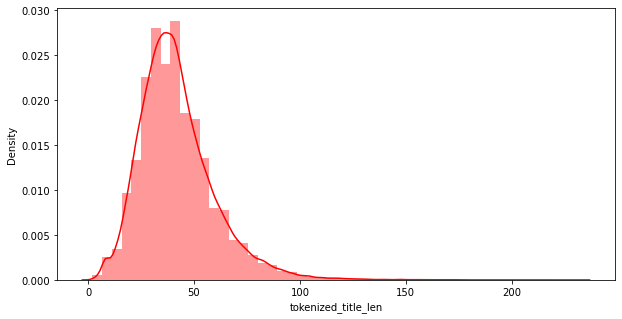

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(train['tokenized_title_len'], color='r')

In [11]:
train['tokenized_title_len'].describe()

count    174304.000000
mean         41.825695
std          17.751998
min           2.000000
25%          30.000000
50%          39.000000
75%          51.000000
max         232.000000
Name: tokenized_title_len, dtype: float64

<AxesSubplot:xlabel='tokenized_content_len', ylabel='Density'>

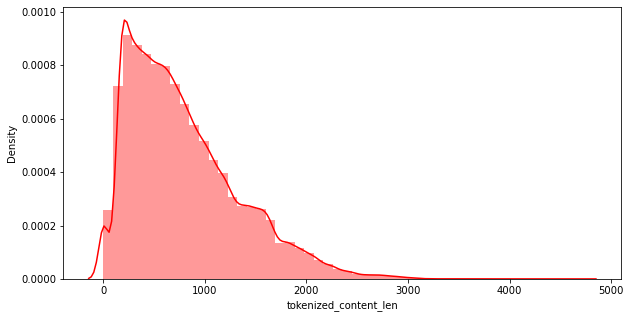

In [12]:
plt.figure(figsize=(10, 5))
sns.distplot(train['tokenized_content_len'], color='r')

In [13]:
train['tokenized_content_len'].describe()

count    174304.000000
mean        789.124868
std         541.200253
min           1.000000
25%         366.000000
50%         672.000000
75%        1092.000000
max        4705.000000
Name: tokenized_content_len, dtype: float64

<AxesSubplot:xlabel='tokenized_keyword_len', ylabel='Density'>

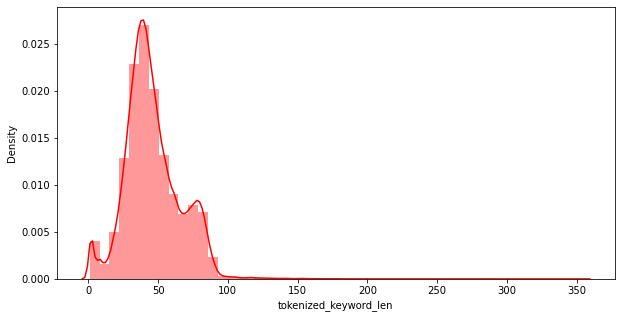

In [14]:
plt.figure(figsize=(10, 5))
sns.distplot(train['tokenized_keyword_len'], color='r')

In [15]:
train['tokenized_keyword_len'].describe()

count    174304.000000
mean         46.053739
std          19.889750
min           1.000000
25%          33.000000
50%          43.000000
75%          57.000000
max         354.000000
Name: tokenized_keyword_len, dtype: float64

In [20]:
max_features = 200000
max_title_len = 300
max_content_len = 1000
max_keyword_len = 300
embed_size = 100
VALIDATION_SPLIT = 0.4
version = 'v2'

In [19]:
train['doc'] = train['tokenized_title'] +'. '+ train['tokenized_content'] +'. '+ train['tokenized_keyword']

In [21]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(train['doc'])

In [22]:
with open('./tokenizer/{}_tokenizer.pkl'.format(version),'wb') as f:
    pkl.dump(tokenizer, f, protocol=pkl.HIGHEST_PROTOCOL)

In [23]:
data_title = np.zeros((len(train['tokenized_title']), max_title_len), dtype='int32')

for i, doc in tqdm(enumerate(train['tokenized_title'])):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        if k < max_title_len and tokenizer.word_index[word] < max_features:
            data_title[i,k] = tokenizer.word_index[word]
            k = k+1

174304it [00:02, 61295.61it/s]


In [24]:
data_content = np.zeros((len(train['tokenized_content']), max_content_len), dtype='int32')

for i, doc in tqdm(enumerate(train['tokenized_content'])):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        if k < max_content_len and tokenizer.word_index[word] < max_features:
            data_content[i,k] = tokenizer.word_index[word]
            k = k+1        

174304it [00:37, 4691.41it/s]


In [26]:
data_keyword = np.zeros((len(train['tokenized_keyword']), max_keyword_len), dtype='int32')

for i, doc in tqdm(enumerate(train['tokenized_keyword'])):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        if k < max_content_len and tokenizer.word_index[word] < max_features:
            data_keyword[i,k] = tokenizer.word_index[word]
            k = k+1        

174304it [00:02, 60692.80it/s]


In [27]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 161089 unique tokens.


In [28]:
Y = pd.get_dummies(train['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (174304, 46)


In [29]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [30]:
indices = np.arange(data_title.shape[0])
np.random.shuffle(indices)
data_title = data_title[indices]
data_content = data_content[indices]
data_keyword = data_keyword[indices]

Y = Y[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data_title.shape[0])

x_train_title = data_title[:-nb_validation_samples]
x_train_content = data_content[:-nb_validation_samples]
x_train_keyword = data_keyword[:-nb_validation_samples]
y_train = Y[:-nb_validation_samples]

x_val_title = data_title[-nb_validation_samples:]
x_val_content = data_content[-nb_validation_samples:]
x_val_keyword = data_keyword[-nb_validation_samples:]
y_val = Y[-nb_validation_samples:]

print('Number of positive and negative reviews in traing and validation set')
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
[85475, 773, 175, 86, 35, 1014, 41, 65, 198, 72, 385, 124, 150, 357, 1030, 101, 297, 89, 925, 2961, 658, 309, 88, 1102, 2106, 487, 180, 379, 263, 595, 131, 527, 167, 311, 321, 172, 648, 178, 165, 111, 272, 37, 33, 231, 65, 694]
[57096, 488, 100, 57, 22, 684, 37, 48, 141, 34, 273, 76, 118, 218, 642, 64, 209, 65, 625, 1977, 401, 187, 60, 738, 1414, 323, 136, 241, 186, 433, 103, 395, 93, 222, 202, 119, 412, 88, 97, 91, 169, 30, 18, 120, 26, 443]


### 임베딩 매트릭스 생성(Glove)

In [36]:
GLOVE_DIR = "./word-embeddings/glove/glove.txt"
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf-8')
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 358043 word vectors.


In [37]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 88358 which is 54.85 % of total words


In [38]:
embedding_layer_title = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_title_len, trainable=False)
embedding_layer_content = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_content_len, trainable=False)
embedding_layer_keyword = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_keyword_len, trainable=False)

## Model

In [39]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'W_regularizer': self.W_regularizer,
            'u_regularizer': self.u_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'u_constraint': self.u_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [40]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [41]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [42]:
### input1
word_input1 = Input(shape=(max_title_len,), dtype='float32')
word_sequences = embedding_layer_title(word_input1)
conv_layer = Dropout(0.5)(Conv1D(filters=64, kernel_size=7, activation = 'relu', kernel_regularizer=l2_reg)(word_sequences))
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
#pool = GlobalMaxPooling1D()(pool)
x1 = Flatten()(pool)
x1 = Dropout(0.5)(Dense(128, activation= 'relu',kernel_regularizer=l2_reg)(x1))


### input content
word_input2 = Input(shape=(max_content_len,), dtype='float32')
word_sequences = embedding_layer_content(word_input2)
conv_layer = Dropout(0.5)(Conv1D(filters=64, kernel_size=7, activation = 'relu', kernel_regularizer=l2_reg)(word_sequences))
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
#pool = GlobalMaxPooling1D()(conv_layer)
x2 = Flatten()(pool)
x2 = Dropout(0.5)(Dense(128, activation= 'relu',kernel_regularizer=l2_reg)(x2))


### input reversed content
word_input3 = Input(shape=(max_keyword_len,), dtype='float32')
word_sequences = embedding_layer_keyword(word_input3)
conv_layer = Dropout(0.5)(Conv1D(filters=64, kernel_size=7, activation = 'relu', kernel_regularizer=l2_reg)(word_sequences))
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=64, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
conv_layer = Conv1D(filters=128, kernel_size=5, activation = 'relu')(pool)
pool = MaxPooling1D(2)(conv_layer)
#pool = GlobalMaxPooling1D()(conv_layer)
x3 = Flatten()(pool)
x3 = Dropout(0.5)(Dense(128, activation= 'relu',kernel_regularizer=l2_reg)(x3))


concat = Concatenate()([x1, x2, x3])
dense = Dense(128, activation= 'relu',kernel_regularizer=l2_reg)(concat)
preds = Dense(46, activation='softmax')(dense)


model = Model(inputs = [word_input1, word_input2, word_input3], outputs = preds)


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 100)     16109000    input_1[0][0]                    
____________________________________________________________________________________________

In [45]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_m])

checkpoint = ModelCheckpoint('./save_models/{}'.format(version) + '_best_{epoch:02d}.h5',
                             verbose=0,
                             monitor='val_loss',
                             save_best_only=False,
                             mode='auto')

In [47]:
history = model.fit([x_train_title, x_train_content, x_train_keyword], y_train,
                    validation_data = ([x_val_title, x_val_content, x_val_keyword], y_val),
                    epochs = 50,
                    batch_size = 64,
                    callbacks = [checkpoint])

Train on 104583 samples, validate on 69721 samples
Epoch 1/50
104583/104583 [==============================] - 76s 731us/step - loss: 0.8980 - accuracy: 0.8175 - f1_m: 0.8132 - val_loss: 0.7923 - val_accuracy: 0.8235 - val_f1_m: 0.8106
Epoch 2/50
104583/104583 [==============================] - 72s 689us/step - loss: 0.7275 - accuracy: 0.8249 - f1_m: 0.8267 - val_loss: 0.6678 - val_accuracy: 0.8329 - val_f1_m: 0.8372
Epoch 3/50
104583/104583 [==============================] - 72s 688us/step - loss: 0.6617 - accuracy: 0.8320 - f1_m: 0.8362 - val_loss: 0.6188 - val_accuracy: 0.8413 - val_f1_m: 0.8430
Epoch 4/50
104583/104583 [==============================] - 72s 691us/step - loss: 0.6182 - accuracy: 0.8392 - f1_m: 0.8438 - val_loss: 0.6011 - val_accuracy: 0.8441 - val_f1_m: 0.8489
Epoch 5/50
104583/104583 [==============================] - 74s 712us/step - loss: 0.5888 - accuracy: 0.8437 - f1_m: 0.8482 - val_loss: 0.5907 - val_accuracy: 0.8424 - val_f1_m: 0.8468
Epoch 6/50
104583/104583

KeyboardInterrupt: 

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Inference

In [48]:
test = pd.read_csv('./data/test.csv')

In [49]:
from keras.utils import CustomObjectScope
from keras.models import load_model

In [50]:
with CustomObjectScope({'AttentionWithContext': AttentionWithContext, 'f1_m': f1_m}):
    model = load_model('./save_models/v2_best_23.h5')

In [51]:
with open('./tokenizer/v2_tokenizer.pkl','rb') as f:
    tokenizer = pkl.load(f)

In [52]:
test = test.fillna('na')

In [53]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [54]:
test['tokenized_title'] = text_preprocessing(test['과제명'])
test['tokenized_content'] = text_preprocessing(test['요약문_연구내용'])
test['tokenized_keyword'] = text_preprocessing(test['요약문_한글키워드'])

test.tokenized_title = test.tokenized_title.apply(lambda x: ' '.join(x))
test.tokenized_content = test.tokenized_content.apply(lambda x: ' '.join(x))
test.tokenized_keyword = test.tokenized_keyword.apply(lambda x: ' '.join(x))

100%|█████████████████████████████████████████████████████████████████████████| 43576/43576 [00:01<00:00, 25420.98it/s]


In [55]:
title_sent_lens = []
title_sent_nums = []
title_paras = []
title_texts = []
for idx in range(test.tokenized_title.shape[0]):
    text = test.tokenized_title[idx]
    title_texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    title_sent_nums.append(len(sentences))
    for sent in sentences:
        title_sent_lens.append(len(text_to_word_sequence(sent)))
    title_paras.append(sentences)


content_sent_lens = []
content_sent_nums = []
content_paras = []
content_texts = []

for idx in range(test.tokenized_content.shape[0]):
    text = test.tokenized_content[idx]
    content_texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    content_sent_nums.append(len(sentences))
    for sent in sentences:
        content_sent_lens.append(len(text_to_word_sequence(sent)))
    content_paras.append(sentences)
    

keyword_sent_lens = []
keyword_sent_nums = []
keyword_paras = []
keyword_texts = []

for idx in range(test.tokenized_keyword.shape[0]):
    text = test.tokenized_content[idx]
    keyword_texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    keyword_sent_nums.append(len(sentences))
    for sent in sentences:
        keyword_sent_lens.append(len(text_to_word_sequence(sent)))
    keyword_paras.append(sentences)

In [56]:
text_title = test.tokenized_title
text_content = test.tokenized_content
text_keyword = test.tokenized_keyword

In [57]:
data_title = np.zeros((len(text_title), max_title_len), dtype='int32')
for i, doc in tqdm(enumerate(text_title)):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        try:
            if k < max_title_len and tokenizer.word_index[word] < max_features:
                data_title[i,k] = tokenizer.word_index[word]
                k = k+1
        except:
            pass
    
    
data_content = np.zeros((len(content_texts), max_content_len), dtype='int32')
for i, doc in tqdm(enumerate(content_texts)):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        try:
            if k<max_content_len and tokenizer.word_index[word]<max_features:
                data_content[i,k] = tokenizer.word_index[word]
                k = k+1
        except:
            pass
        
        
data_keyword = np.zeros((len(keyword_texts), max_keyword_len), dtype='int32')
for i, doc in tqdm(enumerate(text_keyword)):
    wordTokens = text_to_word_sequence(doc)
    k=0
    for _, word in enumerate(wordTokens):
        try:
            if k<max_content_len and tokenizer.word_index[word]<max_features:
                data_keyword[i,k] = tokenizer.word_index[word]
                k = k+1
        except:
            pass

43576it [00:00, 59688.78it/s]
43576it [00:09, 4654.31it/s]
43576it [00:00, 61022.50it/s]


In [58]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 161089 unique tokens.


In [59]:
pred_test = model.predict([data_title, data_content, data_keyword], batch_size = 64)

In [60]:
pred_test.shape

(43576, 46)

In [61]:
pred = np.argmax(pred_test, axis=1)

In [62]:
pred.shape

(43576,)

In [63]:
sample_submission = pd.read_csv('./submission/sample_submission.csv')

In [64]:
sample_submission['label'] = pred
sample_submission.to_csv('./submission/cnn_{}.csv'.format(version),index=False)

In [65]:
sample_submission['label'].value_counts()

0     39254
24      667
5       394
19      369
14      302
31      257
23      240
1       233
36      186
29      162
25      133
13      130
27      122
45      120
40      112
33       91
18       86
21       85
43       75
34       70
10       65
35       63
8        58
37       38
16       34
28       33
2        33
20       29
9        27
15       23
7        15
30       11
12       10
44        9
4         7
11        5
39        5
26        5
32        5
22        4
3         4
41        3
38        2
Name: label, dtype: int64